# Mapping Survival Probability to Channel Density

Loading BokehJS ...


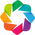

In [74]:
import numpy as np
import pandas as pd
import mscl_utils as mscl
import bokeh.io
import bokeh.plotting
import holoviews as hv 
import theano.tensor as tt
from tqdm import tqdm_notebook, tqdm
import bebi103
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mscl.set_plotting_style()
bokeh.io.output_notebook()
sns.set_palette('deep', color_codes=True)
hv.extension('bokeh')

In [204]:
import imp
imp.reload(mscl)

<module 'mscl_utils' from '/Users/gchure/lab/PhillipsLab201401-XXX/lab_code/mscl_analysis/mscl_utils.py'>

In [76]:
%opts Curve [width=600, height=400, bgcolor='whitesmoke', show_grid=True]
%opts BoxWhisker [width=600, height=400, bgcolor='whitesmoke', show_grid=True]
%opts Scatter [width=600, height=400, bgcolor='whitesmoke', show_grid=True]

In [77]:
# Load the two datasets
cal_data = pd.read_csv('../data/csv/compiled_calibration_data.csv')
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Make one dataframe containing the same axes.
cal_keys = cal_data.keys()
shock_keys = shock_data.keys()
for key in shock_keys:
    if key not in cal_keys:
        shock_data.drop(key, axis=1, inplace=True)

# Make a single dataframe
cal_data.insert(0, 'data_set', 'calibration')
shock_data.insert(0, 'data_set', 'shock')
data = pd.concat([cal_data, shock_data], ignore_index=True)

# Adjust the rescaled intensity to account for exposure. 
frac_exp = data['exposure_ms'].max() / data['exposure_ms']
data['rescaled_intensity'] = (data['intensity'] - data['mean_bg']) * frac_exp


In [4]:
bw = hv.BoxWhisker(data, kdims=['rbs', 'date'], vdims=['rescaled_intensity'])
bw

:BoxWhisker   [rbs,date]   (rescaled_intensity)

In [5]:
bw = hv.BoxWhisker(shock_data, kdims=['rbs'], vdims=['rescaled_intensity'])
bw

:BoxWhisker   [rbs]   (rescaled_intensity)

In [6]:
%%opts BoxWhisker [width=600]
# boxwhisker = hv.BoxWhisker(data[(data.rbs=='10sd1') | (data.rbs == 'sd0') | (data.rbs == 'sd1')], vdims=['rescaled_intensity'], kdims=['rbs', 'date'])
boxwhisker = hv.BoxWhisker(shock_data[shock_data.rbs=='sd1'], vdims=['rescaled_intensity'], kdims=['rbs', 'date'])
boxwhisker

:BoxWhisker   [rbs,date]   (rescaled_intensity)

## Analyzing the shock data 

In [78]:
# Look at the intensity distribution for survivors vs goners. 
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Prune it by excluding negative values and removing 10sd1.
shock_data = shock_data[(shock_data['rbs'] != '10sd1')  & (shock_data['rescaled_intensity'] > 0)]

In [79]:
# Convert based off of our standard candle. 
CHANNEL_NUM = 340
CHANNEL_ERR = 68
PERC_ERR = CHANNEL_ERR / CHANNEL_NUM

# Compute the reference values from the merged data. 
data = data[data['rescaled_intensity'] > 0]

# Candle strain is MLG910
candle_strain = data[data['rbs']=='mlg910']
candle_int = candle_strain['area'] * candle_strain['rescaled_intensity']
au_per_channel = np.mean(candle_int / CHANNEL_NUM)
au_per_channel_err = PERC_ERR * au_per_channel
print('The standard candle is {0} ± {1} a.u. per channel'.format(int(au_per_channel), int(au_per_channel_err)))

The standard candle is 4258 ± 851 a.u. per channel


In [80]:
# Include now channel density and error. 
shock_data['channel_density'] = (shock_data['rescaled_intensity'] / au_per_channel).astype(int)
shock_data['density_err'] = (shock_data['channel_density'] * PERC_ERR).astype(int)

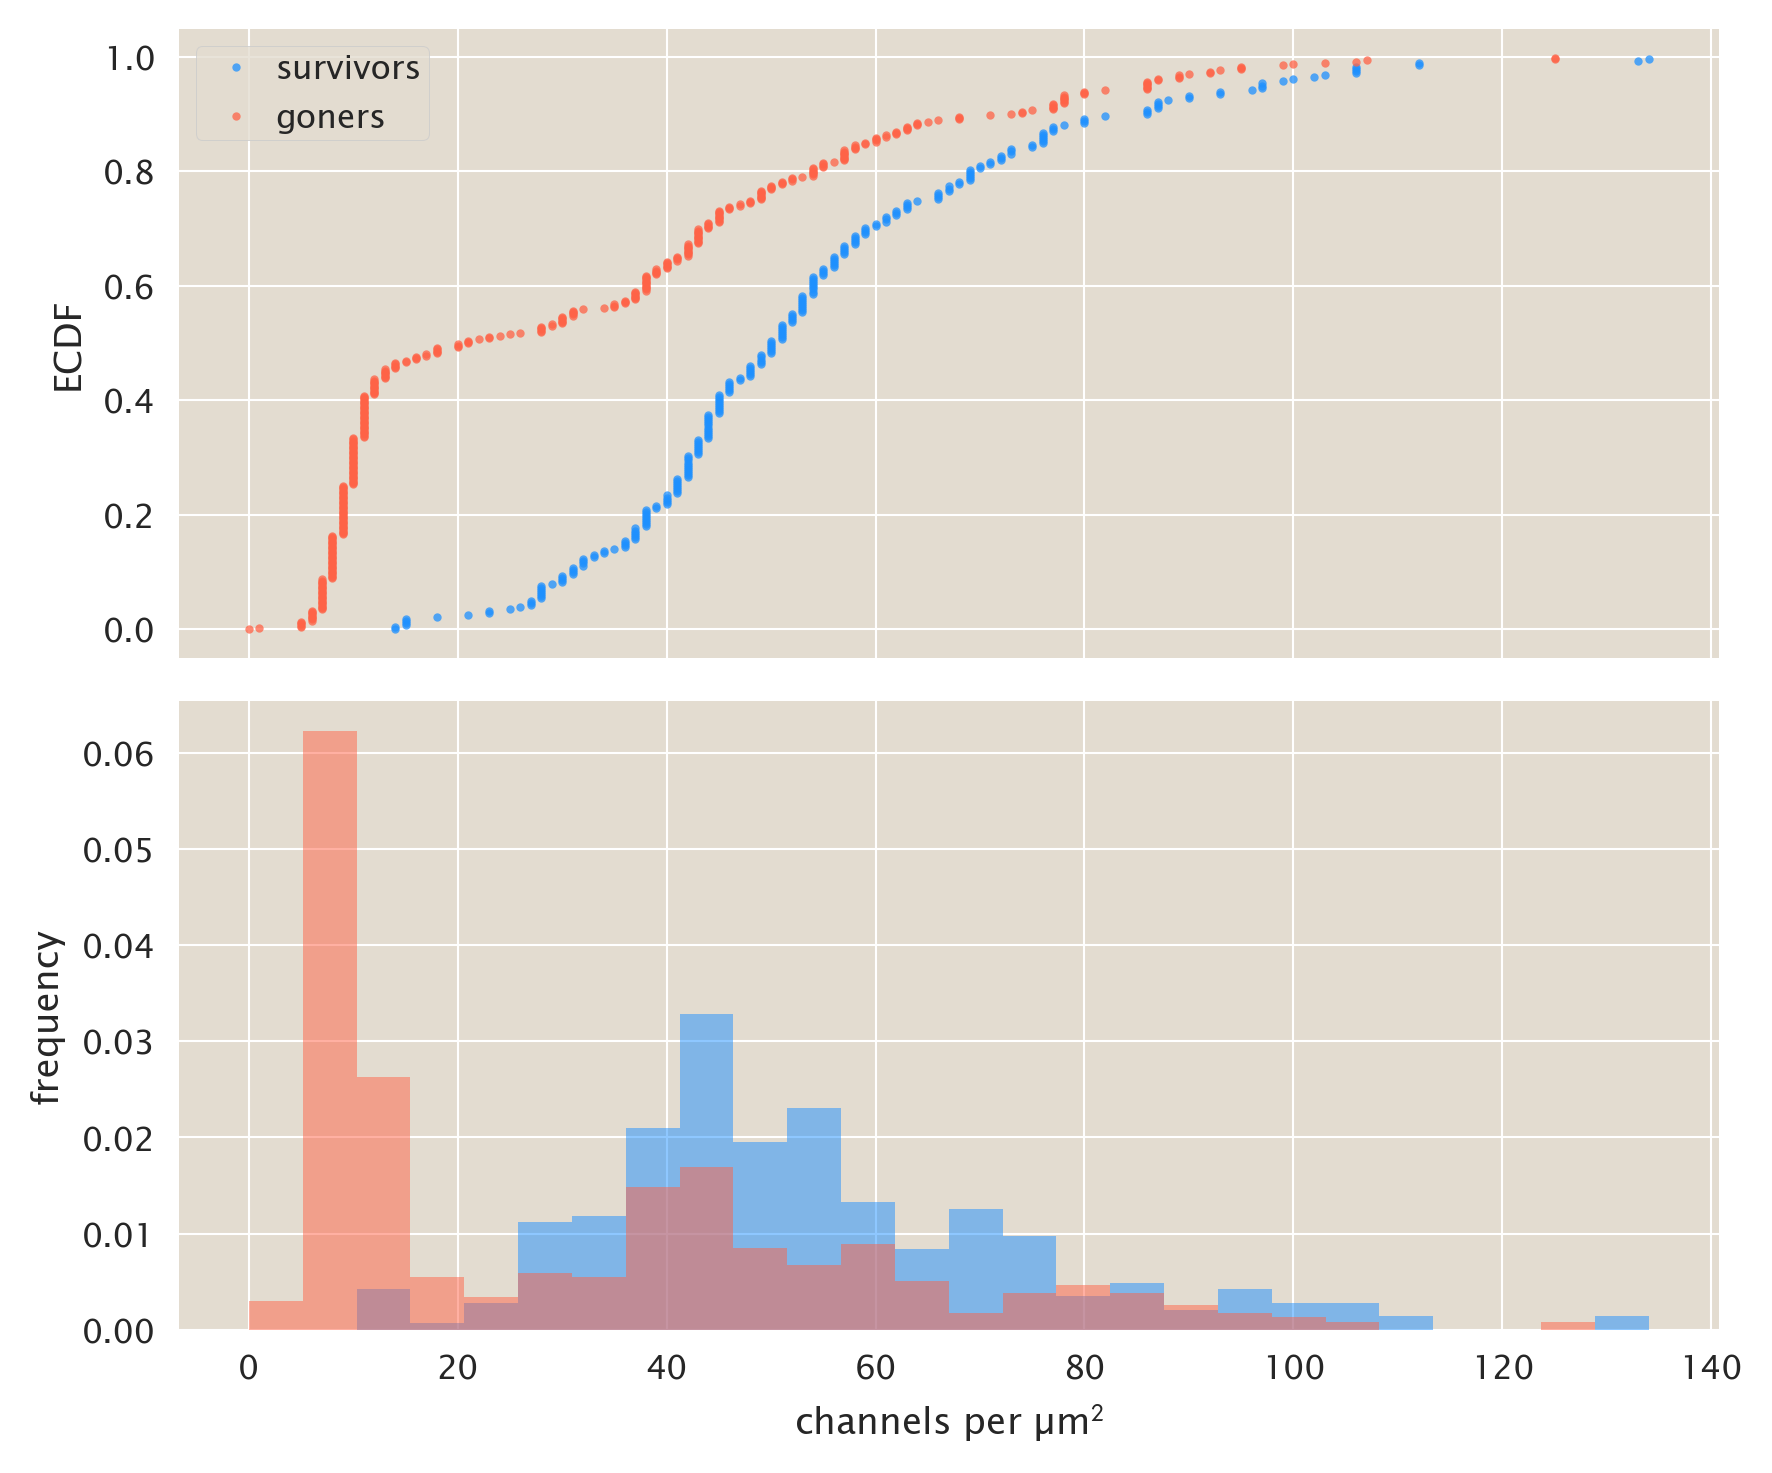

In [192]:
# Compute the ECDF
surv_x, surv_y = mscl.ecdf(shock_data[shock_data['survival']==True]['channel_density'])
death_x, death_y = mscl.ecdf(shock_data[shock_data['survival']==False]['channel_density'])

# Compute the histograms.
bins = np.linspace(shock_data['channel_density'].min(), shock_data['channel_density'].max(), 27)

fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('frequency')
_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5, normed=True)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5, normed=True)
_legend = ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../figs/analysis/survival_density_distribution.pdf', bbox_inches='tight',
           dpi=200)


In [173]:
# Rewrite the binning scheme. 

# 1. Define shock rate.
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'

# 2. Sort the data by channel density.
z = shock_data[shock_data['shock_group'] == 'fast']
sorted_data = z.sort_values(by='channel_density')

# 3. Define the bins from 0 to the max + desired binning
channel_bin = 10
max_density = shock_data['channel_density'].max() + channel_bin
bins = np.arange(0, max_density, channel_bin)

# 4. Set the temporary bin number to 0.
sorted_data['bin_number'] = 0

# 5. Count the number of cells in each bin. 
for i in range(1, len(bins) - 1):
    # Assign bin numbers based on channel density
    inds = (sorted_data['channel_density'] >= bins[i-1]) & (sorted_data['channel_density'] < bins[i+1])
    sorted_data.loc[inds,  'bin_number'] = i

# 6. Identify which bins should be merged.
grouped = sorted_data.groupby('bin_number')['survival'].count()
min_cells = 20 

# Find those with less than the minimum cell number.
bin_counts = grouped.to_dict()
low_bins = grouped[grouped < min_cells].to_dict()

# identifiy the eges of sequential bins with low cell counts.
bin_nos = list(low_bins.keys()) 

# Find the indices at which sequentiality is broken.
sequential = np.where(np.diff(bin_nos) > 1)[0]

# Separate the pairs.
if (len(sequential) == 0) * (len(bin_nos) != 0):
    paired = [bin_nos]    
else: 
    # Need to do fancy indexing here such that it returns even single bins.
    paired = [bin_nos[:sequential[0] + 1]]
    _paired = ([bin_nos[sequential[j-1] + 1:sequential[j] + 1] for j in range(1, len(sequential))])
    for _p in _paired:
        paired.append(_p)   
    paired.append(bin_nos[sequential[-1] + 1:])

# Determine if each pair can meet the minimum number of cells. 
change_bins = {}
for i, pair in enumerate(paired):
    if len(pair) > 1:
        summed = np.sum([bin_counts[p] for p in pair])
        if summed >= min_cells:
            for z in pair:
                change_bins[z] = pair[0]
        else:
            for z in pair:
                change_bins[z] = pair[0] - 1
    else:
        # If there is only one item in the pair, determine which one to add it to.
        if pair[0] == 1:
            change_bins[pair[0]] = pair[0] + 1
        elif pair[0] == sorted_data['bin_number'].max():
            change_bins[pair[0]] = pair[0] - 1
        else:
            change_bins[pair[0]] = pair[0] - 1
change_bins

{3: 2, 8: 8, 9: 8, 10: 8, 11: 8}

In [197]:
# Include some information about the shock group.
shock_data.loc[:, 'shock_group'] = 'all'

# Bin the data in units of 10 channels per square micron.
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin)
binned_data.head()

,index,area,date,exposure_ms,flow_rate,intensity,mean_bg,rbs,survival,rescaled_intensity,channel_density,density_err,shock_group,bin_number
0,561,15.8976,20170714,100,0.018,166722.996899,164038.517434,sd4,False,2684.479465,0,0,all,0
1,543,4.7616,20170714,100,0.018,191719.027121,184315.509854,sd4,False,7403.517267,1,0,all,0
2,386,6.2720,20170316,100,1.000,232978.539598,209289.154034,sd6,False,23689.385564,5,1,all,0
3,324,8.4224,20170316,100,1.000,230911.462795,206927.521606,sd6,False,23983.941189,5,1,all,0
4,243,9.1904,20170316,100,1.000,231440.243311,207238.522105,sd6,False,24201.721206,5,1,all,0


0 0 9
1 10 18
2 20 29
3 30 39
4 40 49
5 50 59
6 60 69
7 70 78
8 80 89
9 90 134


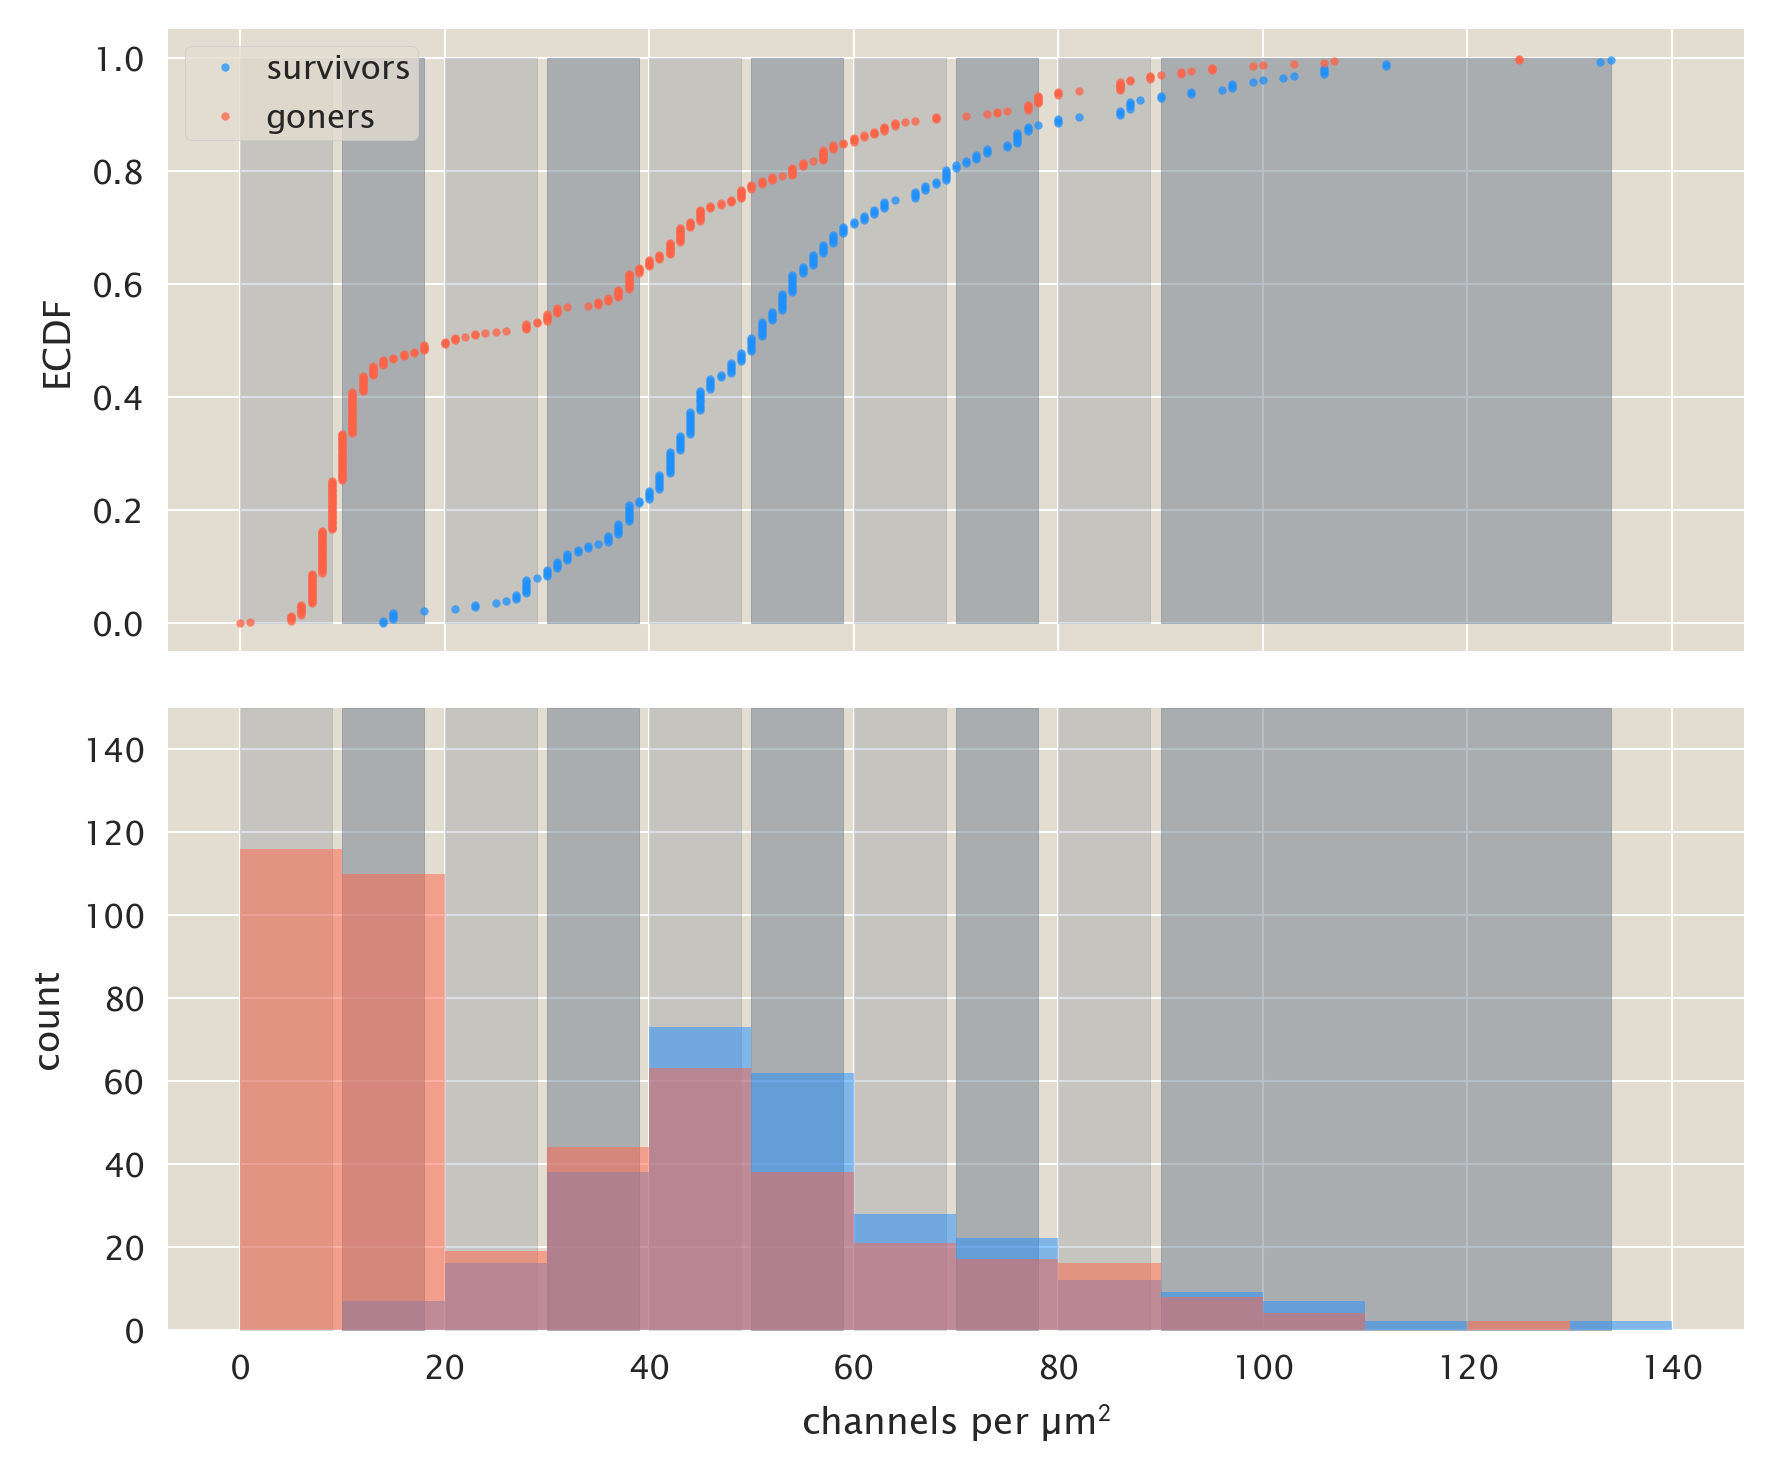

In [190]:
# Show the distribution plot as above, but with the bin numbers indicated. 
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('count')
_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5)

# Shade the bins. 
binned_data.sort_values(by='channel_density', inplace=True)
grouped = binned_data.groupby('bin_number')
bins = np.arange(0, shock_data['channel_density'].max() + channel_bin, channel_bin)
for g, d in grouped:
    print(g, d['channel_density'].min(), d['channel_density'].max())
    if g%2 == 0: 
         alpha=0.25
    else:
        alpha = 0.5 
    for i, a in enumerate(ax):
        if i == 0:
            top = 1
        else: 
             top = 150
        y = np.linspace(0, top, 500)
        a.fill_betweenx(y, d['channel_density'].min(), d['channel_density'].max(), color='slategray', alpha=alpha)
_legend = ax[0].legend(loc='upper left')

ax[1].set_ylim([0, 150])
plt.tight_layout()
# plt.savefig('../figs/analysis/survival_density_distribution.pdf', bbox_inches='tight',
#            dpi=200)



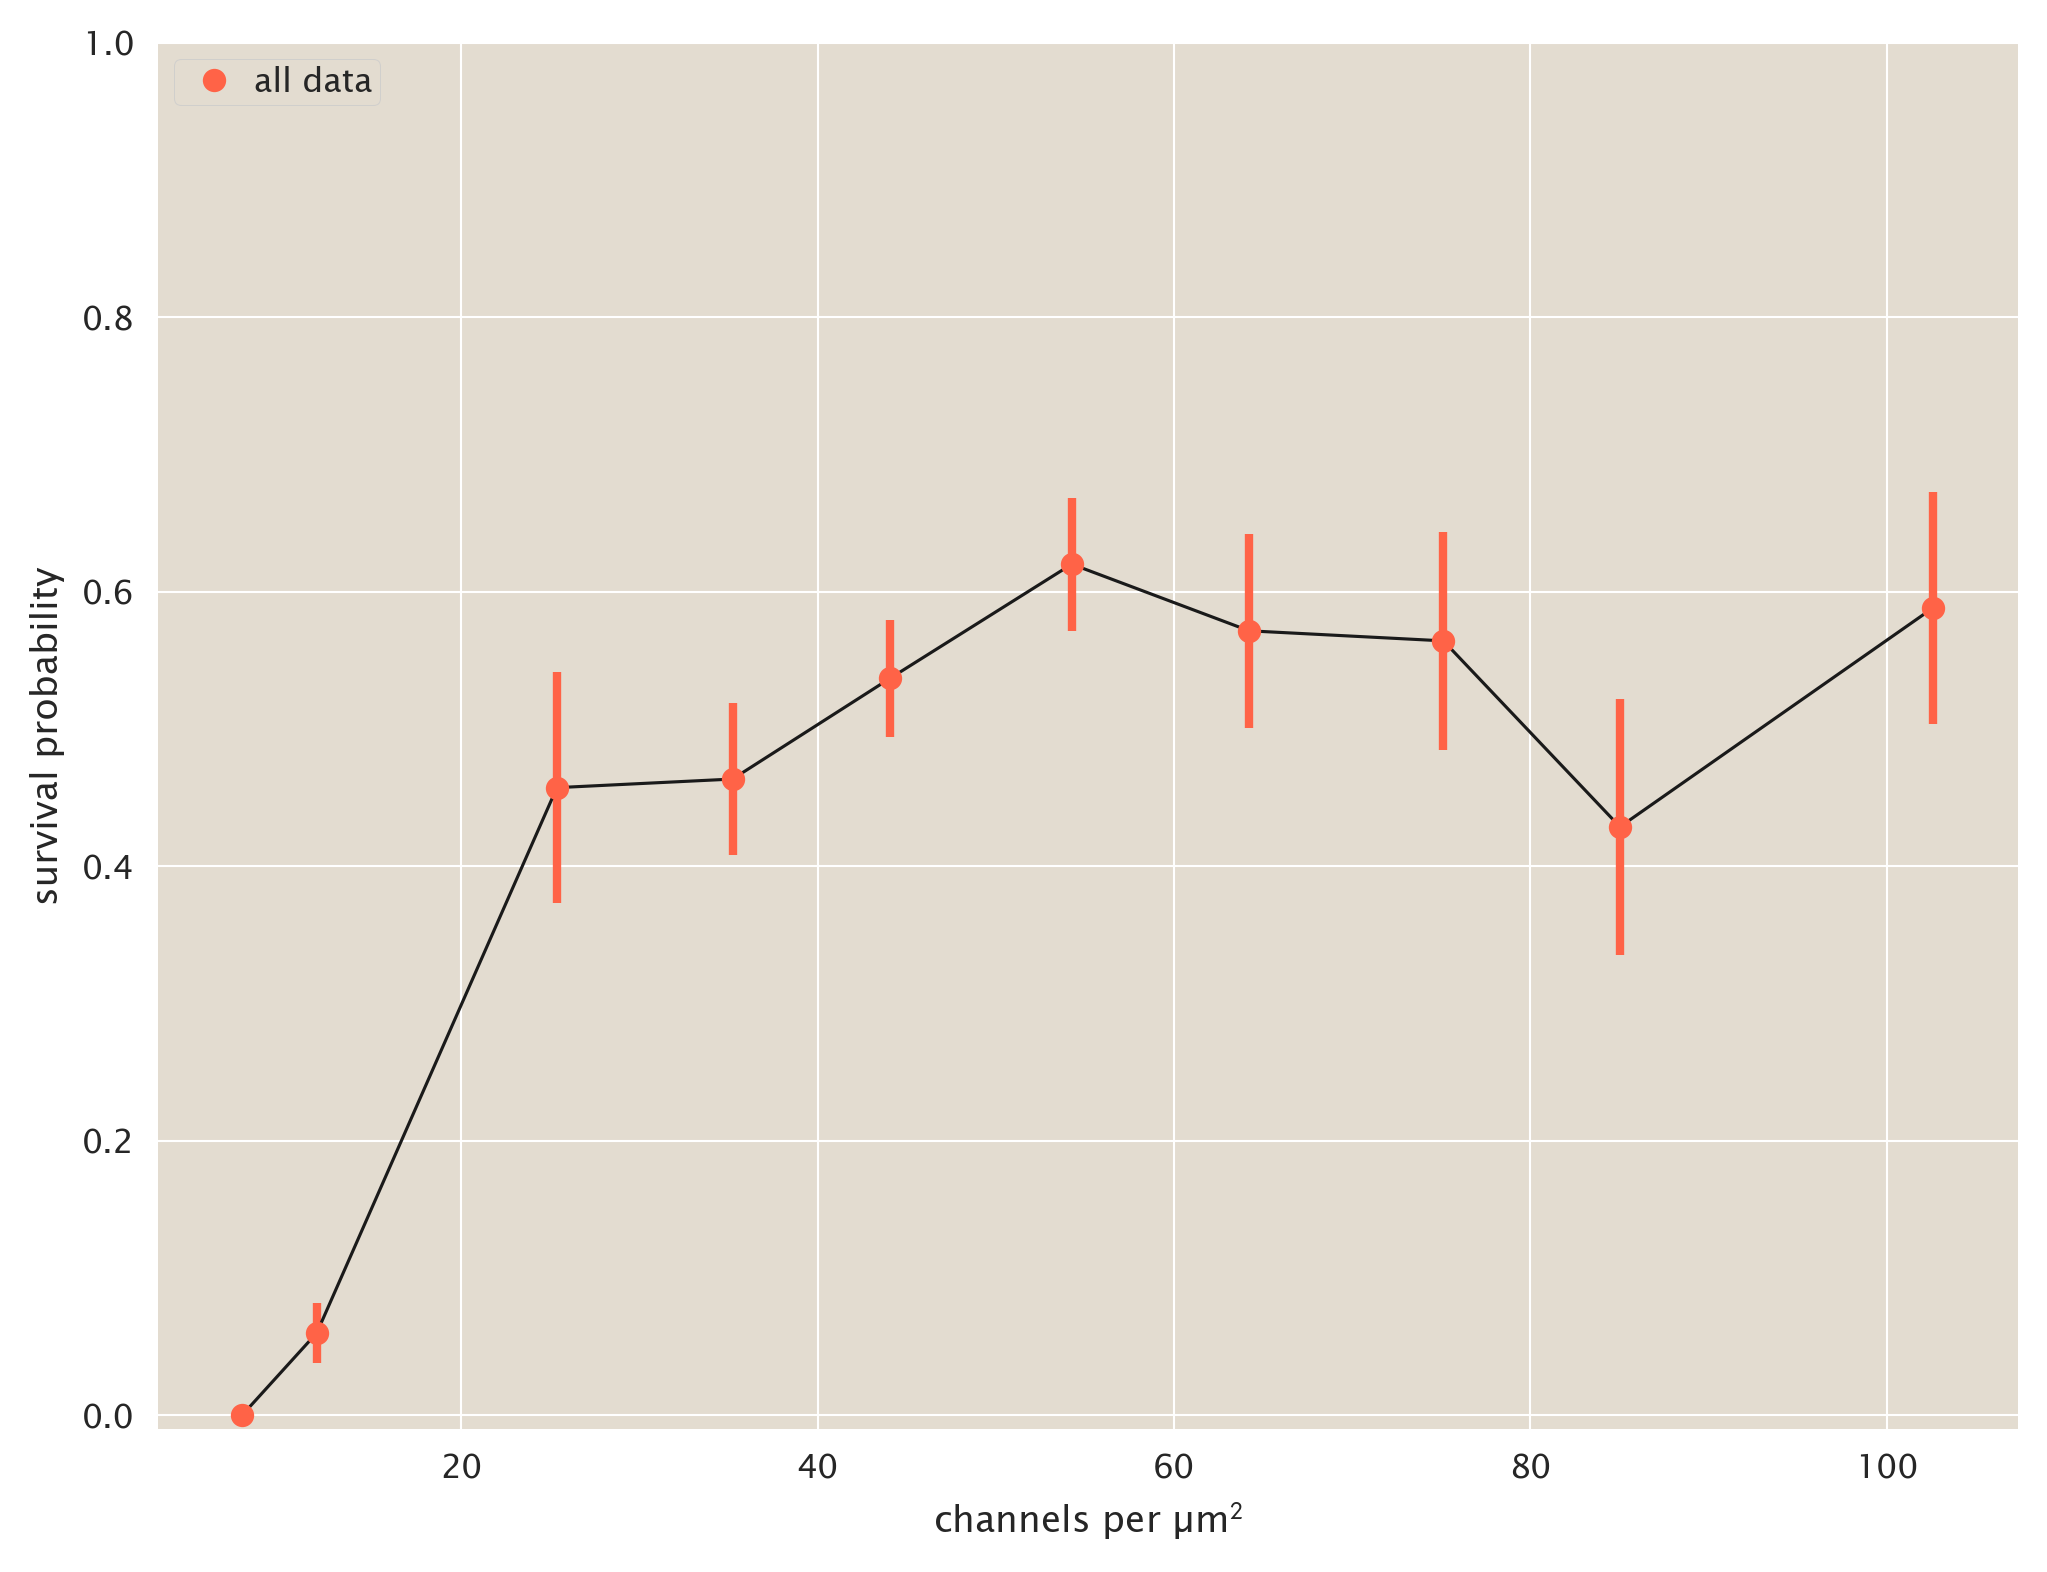

In [196]:
stats = binned_data.groupby('bin_number').apply(mscl.compute_survival_stats)
stats.sort_values(by='mean_chan', inplace=True)

fig, ax = plt.subplots(1,1)
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')
_ = ax.plot(stats['mean_chan'], stats['prob'], lw=0.75, color='k', label='__nolegend__')
_ = ax.errorbar(stats['mean_chan'], stats['prob'], stats['err'], color='tomato',
           linestyle='none', label='__nolegend__')
_ = ax.plot(stats['mean_chan'], stats['prob'], 'o', markerfacecolor='tomato', 
           label='all data')

ax.set_ylim([-0.01, 1])

plt.legend(loc='upper left')
plt.savefig('../figs/analysis/all_data_nbins_10.pdf', bbox_inches='tight')     

In [245]:
# Bin the data by the shock group and show slow and fast. 
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin,
                                  min_cells=10)
stats = mscl.compute_survival_stats(binned_data)


(-0.05, 1)

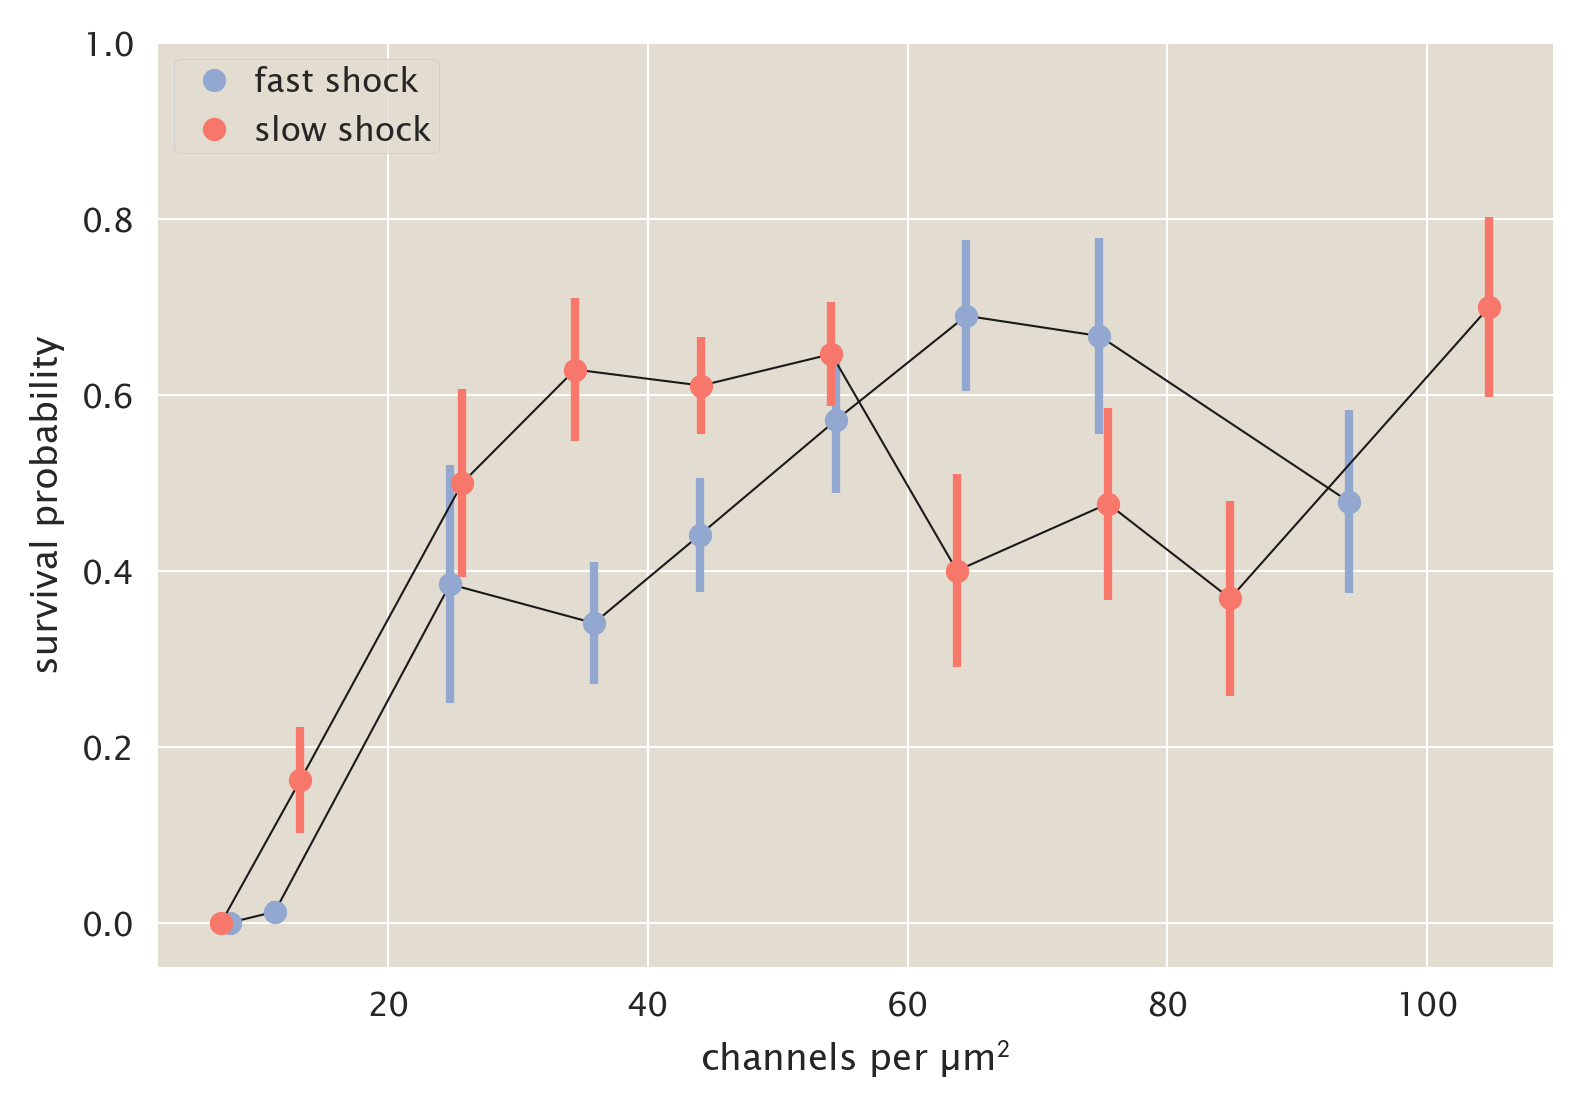

In [246]:
# Generate the figure of the shock rates. 
grouped = stats.groupby('shock_group')
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')

colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
for g, d in grouped:
    _ = ax.errorbar(d['mean_chan'], d['prob'],  d['err'], color=colors[g],
                    label='__nolegend__', linestyle='none')
    _ = ax.plot(d['mean_chan'], d['prob'], 'k-', lw=0.5, label='__nolegend__')
    _ = ax.plot(d['mean_chan'], d['prob'],  'o', color=colors[g], label='{0} shock'.format(g))

_ = ax.legend(loc='upper left')
# _.get_title.set_fontsize(10)
ax.set_ylim([-0.05, 1])

In [ ]:
%%opts Curve [show_grid=True, width=800, height=400]
%%opts Curve (line_alpha=0.75, line_width=2)
%%opts Scatter (size=8)
%%opts ErrorBars (line_width=1)

# Include some information about the shock group.
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'slow'

# Bin the data in units of density. 
channel_bin = 15 
binned_data = bin_by_channel(shock_data, channel_bin=channel_bin)
binned_data = binned_data.sort_values(by='channel_density')
stats = binned_data.groupby(['shock_group', 'bin_number']).apply(compute_stats)
stats.sort_values(by=['mean_chan'], inplace=True)
stats.reset_index(inplace=True)

scatter = hv.Scatter(stats, kdims=['mean_chan'], vdims=['prob', 'shock_group']).groupby('shock_group')
errors = hv.ErrorBars(stats, kdims=['mean_chan', 'prob'], vdims=['err', 'err', 'shock_group']).groupby('shock_group')
curve = hv.Curve(stats, kdims=['mean_chan'], vdims=['prob', 'err', 'shock_group']).groupby('shock_group')
(curve.overlay('shock_group') * scatter.overlay('shock_group') * errors.overlay('shock_group'))

## Logistic Regression 

In [ ]:
# Remove the '10sd1' data from the dataframe.
# data = data[(data['rbs'] != '10sd1')]
p = mscl.bokeh_boiler(x_axis_label='channels per sq. micron', y_axis_label='survival')
# shock_data = shock_data[(shock_data['rbs'] != '10sd1')]
grouped = shock_data.groupby('survival')
survival = shock_data[shock_data['survival'] == True]
death = shock_data[shock_data['survival'] == False]
p.inverted_triangle(survival['channel_density'], survival['survival'].astype(int), color='slategray',
                   size=10, alpha=0.5)
p.triangle(death['channel_density'], death['survival'].astype(int), color='tomato',
          size=10, alpha=0.5)
bokeh.io.show(p)

In [ ]:
def logit(val):
    return tt.exp(val) / (1 + tt.exp(val))

As I've discussed before, the model for survival is binomial,

$$
P(p_s \, \vert\, \rho) \propto \text{Binomial}(n_i, N_i\, \vert \, p_s, \rho)P(p_s).
$$

However, I don't have the luxury of having many measurements of survival with a single, well-defined channel density. Rather, I would like to know the probability of survival $p_s$ 

which, ignoring the flow rate fly in the ointment (for now), can be written more explicitly as
$$
P(p_s \, \vert\, \rho) \propto \text{Bernoulli}(y_i, p_s(\rho))
$$

In [ ]:
model = pm.Model()
with model:
    beta_0 = pm.Normal('b_0', mu=0, sd=10)
    beta_1 = pm.Normal('b_1', mu=0, sd=10)
    
    rho = shock_data['channel_density'].values
    mu = beta_0 + beta_1 * rho
    like = pm.Bernoulli('like', p=logit(mu), observed=shock_data['survival'].values.astype(int))
    
    # Sample the distribution.
    step = pm.Metropolis()
    burn = pm.sample(draws=100000, step=step, njobs=None)
    step = pm.Metropolis()
    trace = pm.sample(draws=10000, start=burn[-1], step=step)
    df = pm.trace_to_dataframe(trace)
    hpd = pd.DataFrame(pm.stats.hpd(trace))

In [ ]:
df = trace_to_df(trace, model=model)
# stats = compute_mcmc_statistics(df)
mode = np.argmax(df['logp'])
mode = df.iloc[mode]

In [ ]:
rho = np.linspace(0, 200, 500)
cred_region = np.zeros((2, len(rho)))
for i, val in enumerate(rho):
    mu =  df['b_0'].values + df['b_1'].values * rho[i]
    prob = (1 + np.exp(-mu))**-1
    cred_region[:, i] = compute_hpd(prob, mass_frac=0.95) 

In [ ]:
p = mscl.bokeh_boiler()
band_x = np.append(rho, rho[::-1])
band_y = np.append(cred_region[0,:], cred_region[1, :][::-1])
mu = mode['b_0'] + mode['b_1'] * rho
pred = (1 + np.exp(-mu))**-1
p.line(rho, pred, line_width=2, color='dodgerblue')
p.inverted_triangle(survival['channel_density'], survival['survival'].astype(int), color='slategray',
                   size=10, alpha=0.5)
p.triangle(death['channel_density'], death['survival'].astype(int), color='tomato',
          size=10, alpha=0.5)
p.patch(band_x, band_y, color='dodgerblue', fill_alpha=0.3, line_width=0.5, line_alpha=0.3)

bokeh.io.show(p)

In [ ]:

def compute_hpd(trace, mass_frac):
        """
        Returns highest probability density region given by
        a set of samples.
        Parameters
        ----------
        trace : array
            1D array of MCMC samples for a single variable
        mass_frac : float with 0 < mass_frac <= 1
            The fraction of the probability to be included in
            the HPD.  For hreple, `massfrac` = 0.95 gives a
            95% HPD.

        Returns
        -------
        output : array, shape (2,)
            The bounds of the HPD

        Notes
        -----
        We thank Justin Bois (BBE, Caltech) for developing this function.
        http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
        """
        # Get sorted list
        d = np.sort(np.copy(trace))

        # Number of total samples taken
        n = len(trace)

        # Get number of samples that should be included in HPD
        n_samples = np.floor(mass_frac * n).astype(int)

        # Get width (in units of data) of all intervals with n_samples samples
        int_width = d[n_samples:] - d[:n - n_samples]

        # Pick out minimal interval
        min_int = np.argmin(int_width)

        # Return interval
        return np.array([d[min_int], d[min_int + n_samples]])


In [ ]:
import imp
imp.reload(mscl)

In [ ]:
def bin_by_channel(data, groupby='shock_group', channel_bin=10, min_cells=20,
            channel_key='channel_density', survival_key='survival'):
    """
    Bins survival data by a given channel density.
    
    Parameters
    ----------
    data : pandas DataFrame 
        DataFrame containing data with computed channel density,
        survival classifier, and shock speed designation. 
    groupby : list of strings.
        Keys by which to group the survival data. Default is 'shock_group'
    channel_bin : float or int
        Bin width for channel density. Default is 10 channels per unit area. 
    min_cells : int
        Minimum number of cells to consider for each bin.
    channel_key : string
        Column name for channel density. Default is 'channel_density'.
    survival_key : string
        Column name for survival identifier. Default is 'survival'.
    
    Returns:
    --------
    bin_data : pandas DataFrame
        Data frame with binned data.
    """
    
    # Set the bounds for the bins. 
    lower_bound = 0
    upper_bound = int(data[channel_key].max())
    bins = np.arange(lower_bound, upper_bound + channel_bin, channel_bin)

    # Sort the data by channel density
    sorted_data = data.sort_values(by=channel_key)

    # Partition into the bins. 
    bin_numbers = []
    sorted_data['bin_number'] = 0
    sorted_data.reset_index(inplace=True)
    bin_val = 0 
    for i in tqdm_notebook(range(1, len(bins)), desc='Assigning bin numbers'):
        num_cells = 0
        for j in range(len(sorted_data)):
            _rho = sorted_data.iloc[j]['channel_density']
            if (_rho > bins[i-1]) & (_rho < bins[i]):
                sorted_data.set_value(col='bin_number', value=bin_val, index=j)
                num_cells += 1
        if num_cells > 0:
            bin_val += 1

    # Ensure that the bin numbering scheme is sequential.
    bin_data = sorted_data.copy()
    grouped = bin_data.groupby(groupby)
    for g, d in grouped:
        seq_change = {}
        bin_nos = d['bin_number'].unique()
        for i, b in enumerate(bin_nos):
            bin_data.loc[(bin_data['bin_number'] == b) &\
                         (bin_data[groupby] == g), 'bin_number'] = i

    # Regroup the data and congeal bins to a minimum cell number.
    grouped = bin_data.groupby(groupby)
    for g, d in grouped: 
        # Group by bin number.  
        _grouped = d.groupby('bin_number')[survival_key].count()

        # Find those less than the minimum cell number. 
        bin_counts = _grouped.to_dict()
        low_bins = _grouped[_grouped < min_cells].to_dict()

        # Get just the bin numbers.
        bin_nos = list(low_bins.keys())

        # Identify the edges of sequential bins with low cell counts.
        sequential = np.where(np.diff(bin_nos)>1)[0]
        if (len(sequential) == 0) & (len(bin_nos) != 0):
            paired = [bin_nos]
        else:
            # Split them into pairs using fancy indexing. 
            paired = ([bin_nos[sequential[j-1]+1:sequential[j]+1] for j in range(len(sequential))])
            paired[0] = bin_nos[:sequential[0]+1]
            paired.append(bin_nos[sequential[-1]+1:])

        # Loop through each pair and determine if they can meet the minimum.
        change_bins = {}
        for i, pair in enumerate(paired):
            summed = np.sum([bin_counts[p] for p in pair])
            if len(pair) == 1:
                change_bins[pair[0]] = pair[0] - 1
            elif summed >= min_cells:
                for z in pair:
                    change_bins[z] = pair[0]
            else:
                if i < (len(paired) - 1):  
                    ind = int(len(pair) / 2)
                    for z in pair[:ind]:
                        change_bins[z] = pair[0] - 1
                    for z in pair[ind:]:
                        change_bins[z] = pair[0] + 1
                else:
                    for z in pair:                
                        change_bins[z] = pair[0] - 1 

    
        # Loop through the changed bins and change the value of the bin number in the
        # original dataframe. 
        keys = change_bins.keys()
        for key in keys:
            bin_data.loc[(bin_data['shock_group']==g) &\
                            (bin_data['bin_number']==key), 'bin_number'] = change_bins[key] 

    return bin_data 


def compute_survival_stats(df):
    """
    Computes the statistics of survival probabilitiy, number of cells
    
    """
    
    def binomial_probability(df):
        n = np.sum(df==True)
        N = len(df)
        return n / N

    def binomial_err(df):
        n = np.sum(df==True)
        N = len(df)
        return np.sqrt(n * (N - n) / N**3)
    
    return pd.Series({'prob':binomial_probability(df['survival']),\
            'err': binomial_err(df['survival']),
           'mean_chan': df['channel_density'].mean(), 'n_cells': len(df), 'n_surv': np.sum(df['survival'])})


def trace_to_df(trace, model):
    """
    Converts the trace from a pymc3 sampling trace to a
    Pandas DataFrame.
    """

    def compute_logp(chain):
        """
        Computes the log probability of the provided trace
        at a given chain.
        """
        names = trace.varnames
        var_dict = {}
        for n in names:
            var_dict[n] = trace.get_values(n, chains=chain)
        sample_df = pd.DataFrame(var_dict)

        logp = [model.logp(sample_df.iloc[step]
                           ) for step in range(len(sample_df))]
        return logp

    chains = trace.chains
    for c in tqdm(chains, desc='Processing chains'):
        logp = compute_logp(c)
        if c == 0:
            df = pm.trace_to_dataframe(trace, chains=c)
            df.insert(np.shape(df)[1], 'logp', logp)
        else:
            _df = pm.trace_to_dataframe(trace, chains=c)
            _df.insert(np.shape(_df)[1], 'logp', logp)
            df.append(_df, ignore_index=True)

    return df



def compute_mcmc_statistics(df, ignore_vars='logp'):
    """
    Computes the mode and highest probability density (hpd)
    of the parameters in a given dataframe.  """
    # Set up the multi indexing.
    var_names = np.array(df.keys())
    if ignore_vars is not None:
        var_names = var_names[var_names != ignore_vars]

    # Generate arrays for indexing and zip as tuples.
    names = [var for var in var_names] * 3
    stats = ['mode', 'hpd_min', 'hpd_max']
    stats = np.array([[s] * len(var_names) for s in stats]).flatten()
    tuples = list(zip(*[names, stats]))

    # Define the index.
    index = pd.MultiIndex.from_tuples(tuples, names=['var', 'stat'])

    # Determine the mode for each
    mode_ind = np.argmax(df['logp'])
    stat_vals = [df.iloc[mode_ind][var] for var in var_names]
    # Compute the min and max vals of the HPD.
    hpd_min, hpd_max = [], []
    for i, var in enumerate(var_names):
        _min, _max = hpd(df[var], 0.95)
        hpd_min.append(_min)
        hpd_max.append(_max)
    for _ in hpd_min:
        stat_vals.append(_)
    for _ in hpd_max:
        stat_vals.append(_)

    # Add them to the array for the multiindex
    flat_vals = np.array([stat_vals]).flatten()
    var_stats = pd.Series(flat_vals, index=index)

    return var_stats

In [ ]:
binned_data